In [1]:
import duckdb
import json
import os
import requests
import cv2 as cv
import urllib
import numpy as np
from matplotlib import pyplot as plt
import time
import urllib.request

In [2]:
#DATAMOS_API_KEY = os.environ['ETH_KEY']


In [3]:
#urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
#urllib.request.urlretrieve("https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg", "yolov3.cfg")
#urllib.request.urlretrieve("https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names", "coco.names")

('coco.names', <http.client.HTTPMessage at 0x7f39e05ce940>)

In [4]:
url = f'https://apidata.mos.ru/v1/datasets/1500/rows?api_key={DATAMOS_API_KEY}&$top=2&$orderby=global_id'
media_url_tpl = 'https://op.mos.ru/MEDIA/showFile?id={0}'

In [5]:
resp = requests.get(url)
print(resp.json())
img_arr = []
for el in resp.json():
    req = urllib.request.urlopen(media_url_tpl.format(el['Cells']['Photo']))
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv.imdecode(arr, cv.IMREAD_COLOR)
    img_arr.append(img)

[{'global_id': 904476341, 'Number': 1, 'Cells': {'ID': 'PVN_hd_UVAO_4609_2', 'AdmArea': 'Юго-Восточный административный округ', 'District': 'район Лефортово', 'Address': 'Российская Федерация, город Москва, внутригородская территория муниципальный округ Лефортово, Солдатский переулок, дом 8', 'SimpleAddress': 'Солдатский переулок, дом 8', 'Photo': 'f945cd7e-7965-4ebc-aeb4-d617991264f8', 'UNOM': '31428', 'global_id': 904476341, 'geoData': {'coordinates': [37.7038882, 55.766675424], 'type': 'Point'}}}, {'global_id': 904476342, 'Number': 2, 'Cells': {'ID': 'PVN_hd_UVAO_4844_3', 'AdmArea': 'Юго-Восточный административный округ', 'District': 'район Марьино', 'Address': 'Российская Федерация, город Москва, внутригородская территория муниципальный округ Марьино, Луговой проезд, дом 10, корпус 1', 'SimpleAddress': 'Луговой проезд, дом 10, корпус 1', 'Photo': 'f27439e4-3dca-424c-bb75-56a28b470215', 'UNOM': '61132', 'global_id': 904476342, 'geoData': {'coordinates': [37.751322551, 55.645995936],

In [6]:
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

In [7]:
net = cv.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [8]:
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

In [9]:
blobs = cv.dnn.blobFromImages(img_arr, 1/255.0, (416, 416), swapRB=True, crop=False)

In [10]:
net.setInput(blobs)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()

In [11]:
print('time=', t-t0)

time= 3.310190200805664


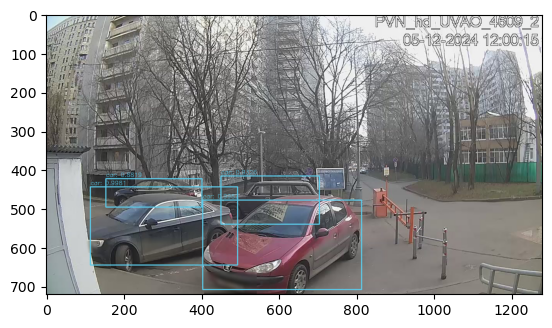

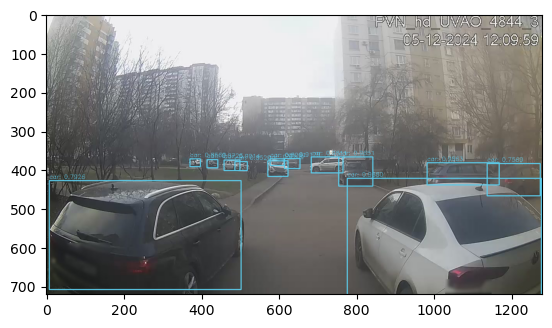

In [12]:
for r in range(0, outputs[0].shape[0]):
    boxes = []
    confidences = []
    classIDs = []
    img = img_arr[r]
    h, w = img.shape[:2]
    
    for output in outputs:
        for detection in output[r]:
            scores = detection[5:] 
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[:4] * np.array([w, h, w, h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                box = [x, y, int(width), int(height)]
                boxes.append(box)
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in colors[classIDs[i]]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
            cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(imgRGB)
    plt.show()